In [226]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from PyHessian.pyhessian.utils import *
from hessian_utils import *
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time
import copy


# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
# How to do this?
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
%matplotlib inline


In [227]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
cuda = torch.cuda.is_available()

cpu


In [228]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [229]:
train_X = mnist_trainset.data
train_y = mnist_trainset.targets
test_X = mnist_testset.data
test_y = mnist_testset.targets

In [230]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(16*8*8, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*8*8)
        x = self.linear(x)
        return x

In [231]:
# train_X = torch.tensor(train_X).permute(0, 3, 1, 2).float()
# test_X = torch.tensor(test_X).permute(0, 3, 1, 2).float()
train_X = (train_X / 255.0).to(device)
test_X = (test_X / 255.0).to(device)
train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
test_y = torch.tensor(test_y, dtype=torch.int64).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]
x_samples = train_X[:50]
y_samples = train_y[:50]

C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_26380\3739243810.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_26380\3739243810.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(test_y, dtype=torch.int64).to(device)


In [232]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X[:1000], train_y[:1000]),
    batch_size=32, shuffle=True)

hessian_loader = []
for i, (x, y) in enumerate(dataloader):
    hessian_loader.append((x.to(device), y.to(device)))

torch.manual_seed(43)    
model_SGD = Net().to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=1e-3)
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=1e-3, momentum=0.9)

In [233]:
losses = []
epochs = 00
for epoch in range(epochs):
    for x, y in hessian_loader:
        optimizer_SGD.zero_grad()
        output = model_SGD(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer_SGD.step()
        losses.append(loss.item())
    print(f'Epoch: {epoch}, Loss: {losses[-1]}')

c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\DeepHessian\PyHessian\density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


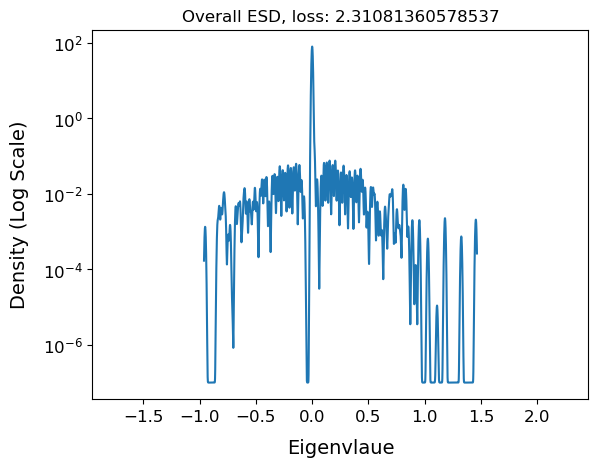

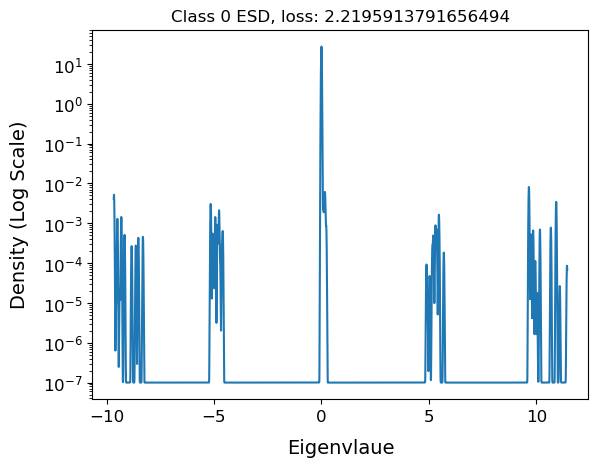

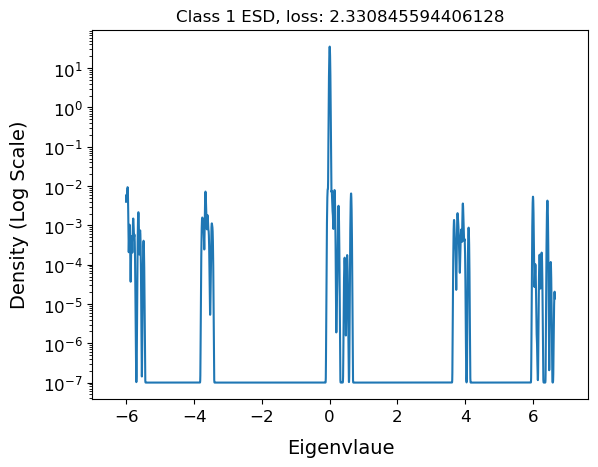

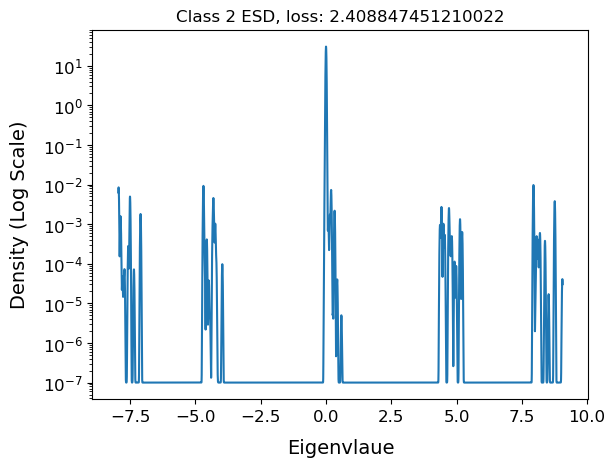

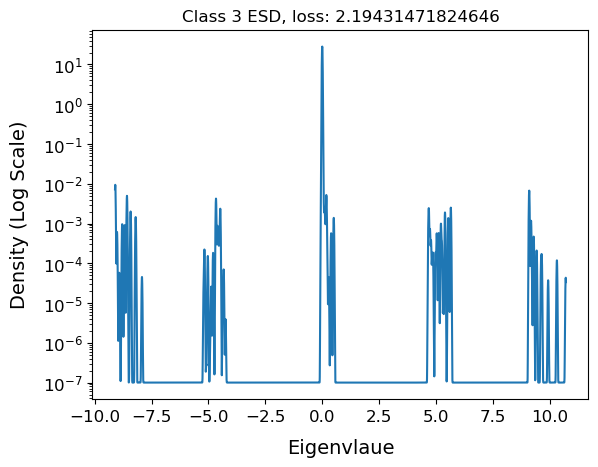

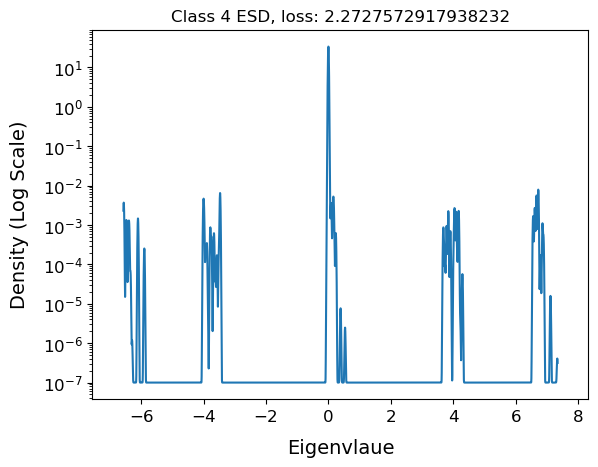

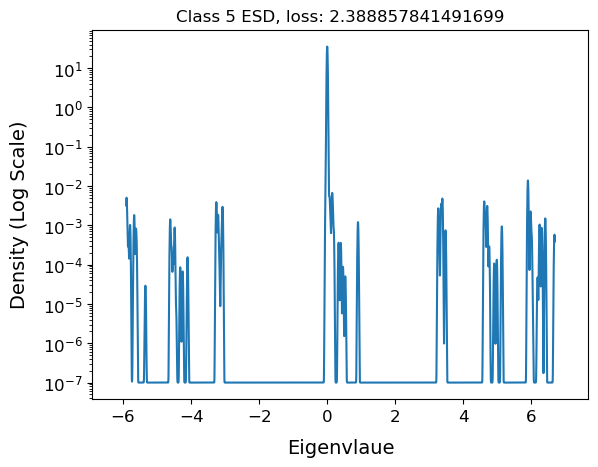

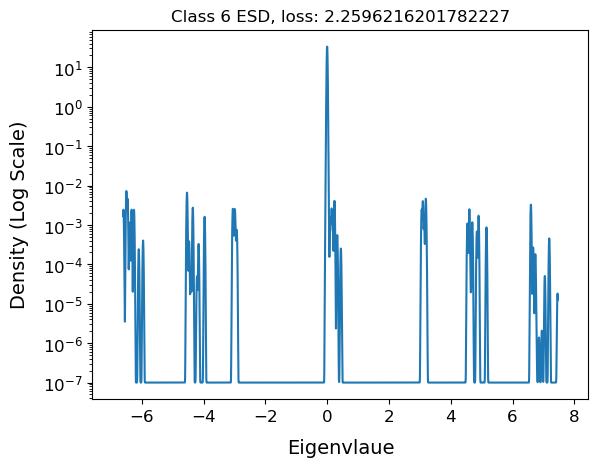

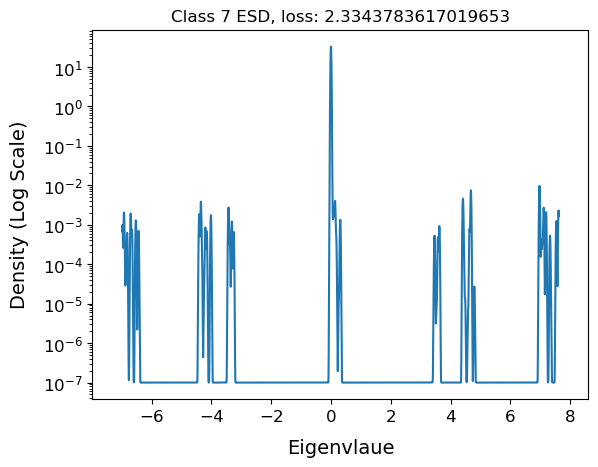

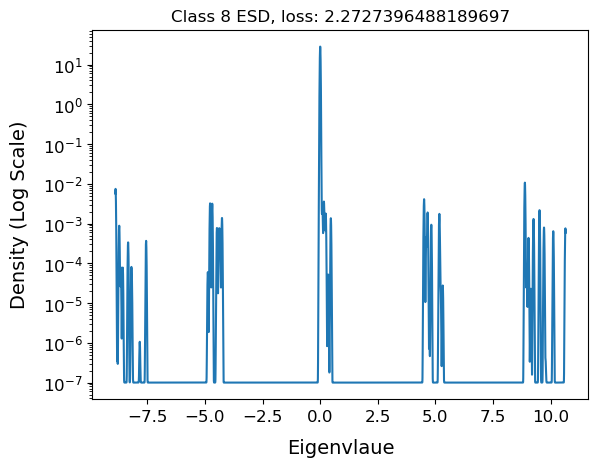

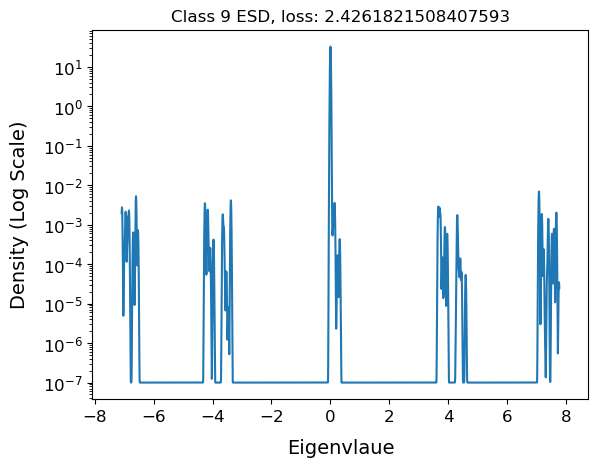

In [235]:
singleton_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_samples, y_samples),
    batch_size=1, shuffle=False)
 
classwise_loader = [[], [], [], [], [], [], [], [], [], []]
for i, (x, y) in enumerate(singleton_dataloader):
    classwise_loader[y.item()].append((x, y))

# Hessian for single samples
classwise_loader = [[arr[0], arr[1]] for arr in classwise_loader]

#Calculating classwise losses
class_losses = [np.mean([criterion(model_SGD(sample[0]), sample[1]).item() for sample in (classwise_loader[i])]) for i in range(10)]
hess = hessian(model_SGD, criterion, dataloader=singleton_dataloader, cuda=cuda)
get_esd_plot(*hess.density(), title=f"Overall ESD, loss: {np.mean(class_losses)}")
for i in range(10):
    hess = hessian(model_SGD, criterion, dataloader=classwise_loader[i], cuda=cuda)
    get_esd_plot(*hess.density(), title=f"Class {i} ESD, loss: {class_losses[i]}")